In [10]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering, KMeans
from skimage.transform import rescale
from scipy.ndimage.filters import gaussian_filter
from scipy import ndimage
dpi=90
import cv2
import seaborn_image as isns
import seaborn as sns

(520, 704) (520, 704)


<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

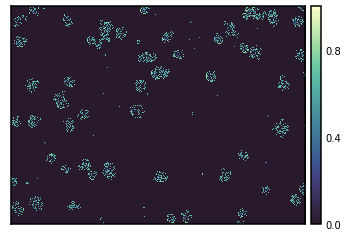

In [46]:
rootdir="/Users/hershalpandya/data/temp_delete/images/livecell_train_val_images/A172/"

img = cv2.imread(rootdir+'A172_Phase_A7_1_00d00h00m_1.tif')
# img=img[:256,:256]
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

thresh_mean = cv2.adaptiveThreshold(img_gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                          cv2.THRESH_BINARY, 3, 5)
  

mask0=1.0*(img_gray>thresh_mean)
img = np.asarray(img_gray, np.float64)
mask0 = np.asarray(mask0, np.float64)
print (mask0.shape,img.shape)

img=cv2.multiply(img,mask0)
img/=np.max(img)

mask = img.astype(bool)
img = img.astype(float)

plt.figure()
# plt.matshow(img)
isns.imgplot(img)

<AxesSubplot:>

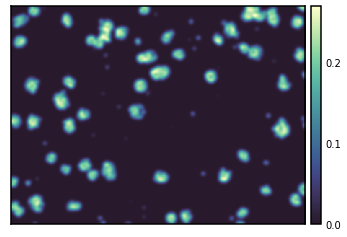

In [45]:
smoothened_img = gaussian_filter(img, sigma=4)

# plt.figure()
# plt.matshow(smoothened_img)
isns.imgplot(smoothened_img)

(189, 2) (188,)
(50, 2) (188,)
estim_n_clusters  50  in image w Npixels:  3640


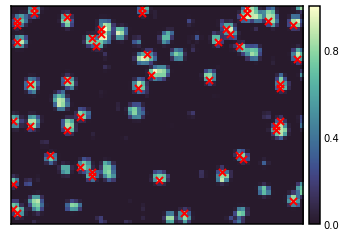

In [49]:
downscale_test=0.1
rescaled_img_test = rescale(smoothened_img, downscale_test, 
                            mode="reflect",anti_aliasing=False, multichannel=False)

rescaled_img_test/=np.max(rescaled_img_test)

# plt.figure(dpi=dpi)
fig, ax = plt.subplots()
isns.imgplot(rescaled_img_test,ax=ax)
# plt.matshow(rescaled_img_test)
# plt.colorbar()

x= rescaled_img_test[rescaled_img_test!=0]
x = rescaled_img_test>np.percentile(x,90)

cluster_loc_test = np.argwhere(x)
min_distance_betwn_clus = 20 # pixels

def dist_calc(x1,x2):
    return np.sqrt((x1[0]-x2[0])**2.0 + (x1[1]-x2[1])**2.0)

gradient = np.array([dist_calc(cluster_loc_test[ix],cluster_loc_test[ix+1]) for ix in range(0,len(cluster_loc_test)-1)])

print (cluster_loc_test.shape, gradient.shape)
cluster_loc_test= cluster_loc_test[1:][gradient>=min_distance_betwn_clus]
print (cluster_loc_test.shape, gradient.shape)

# cluster_loc_test = cluster_loc_test[select]

ax.scatter(cluster_loc_test.T[1],cluster_loc_test.T[0],marker='x',s=50,lw=2,color='r')

estim_n_clusters = len(cluster_loc_test)
print ("estim_n_clusters ", estim_n_clusters, " in image w Npixels: ", np.prod(np.shape(rescaled_img_test)))

In [14]:
downscale=0.3
rescaled_img = rescale(smoothened_img, downscale, mode="reflect",anti_aliasing=False, multichannel=False)
mask = np.ones_like(rescaled_img)
mask = mask.astype(bool)
print (len(mask[mask]))

32916


In [15]:
graph = image.img_to_graph(rescaled_img)
print (graph.shape,rescaled_img.shape, )

# Take a decreasing function of the gradient: an exponential
# The smaller beta is, the more independent the segmentation is of the
# actual image. For beta=1, the segmentation is close to a voronoi
# beta = 20
# eps = 0#1e-6
# graph.data = np.exp(-beta * graph.data / graph.data.std()) + eps

(32916, 32916) (156, 211)


In [16]:
labels = spectral_clustering(graph, n_clusters=estim_n_clusters, random_state=4,verbose=0)
%time

CPU times: user 34 µs, sys: 10 µs, total: 44 µs
Wall time: 10 µs


<AxesSubplot:>

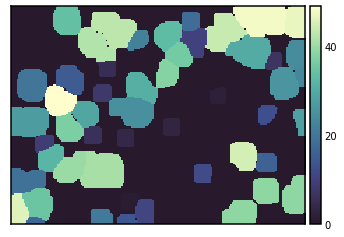

In [17]:
label_im = np.full(mask.shape, -1.)
label_im[mask] = labels

# plt.figure(figsize=(20,10))
# plt.imshow(label_im,cmap='tab20c')
# plt.colorbar()

isns.imgplot(label_im)

In [18]:
slices = ndimage.find_objects(labels.reshape(rescaled_img.shape))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


too big a picture.


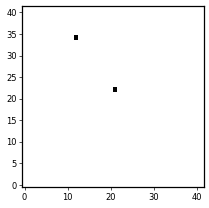

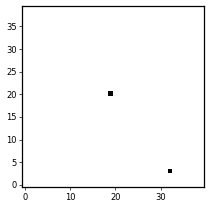

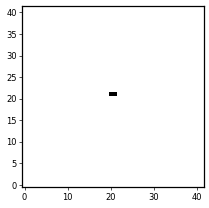

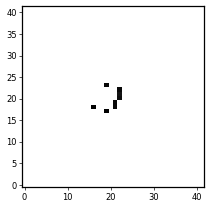

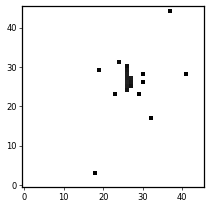

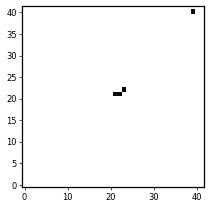

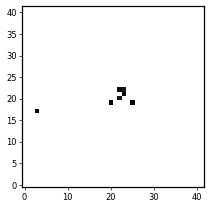

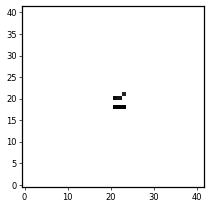

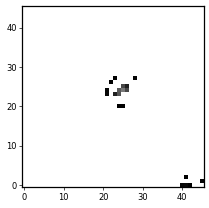

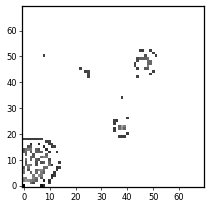

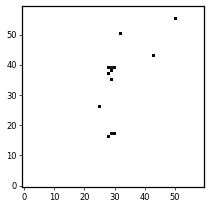

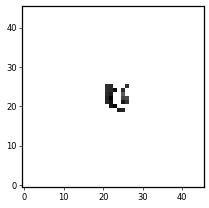

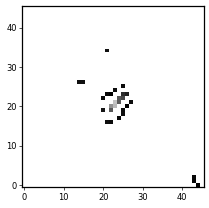

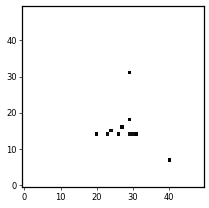

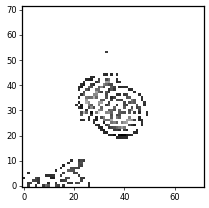

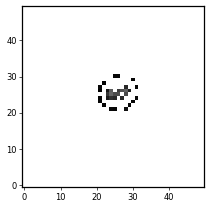

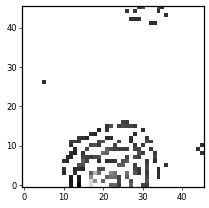

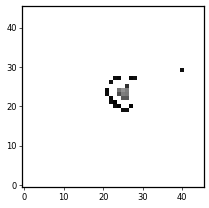

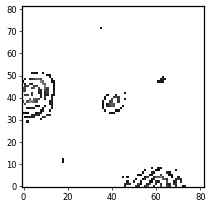

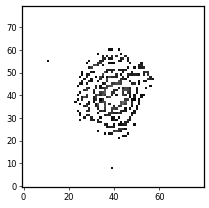

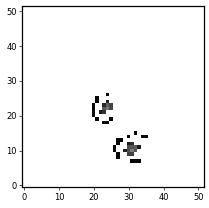

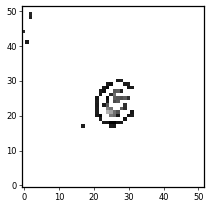

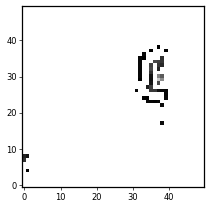

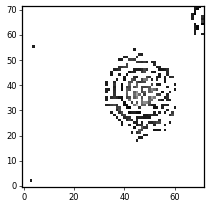

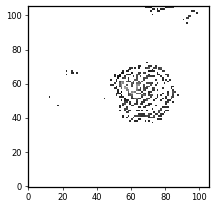

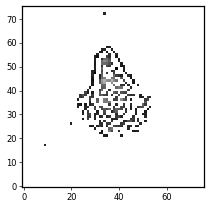

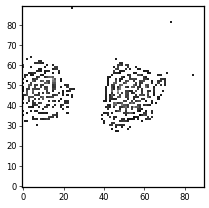

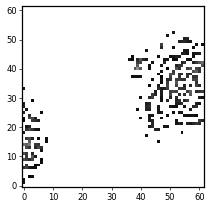

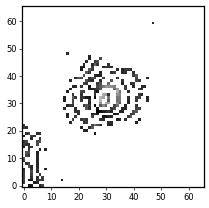

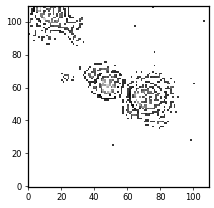

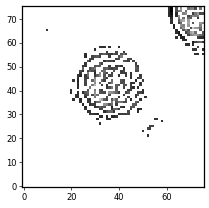

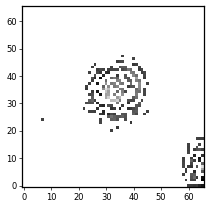

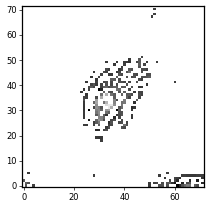

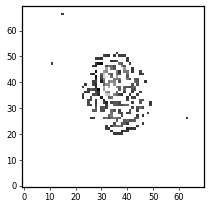

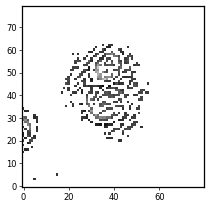

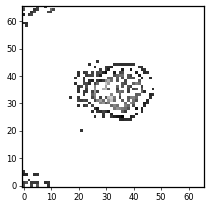

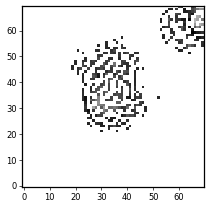

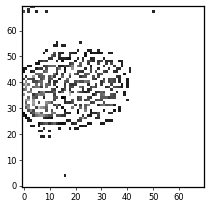

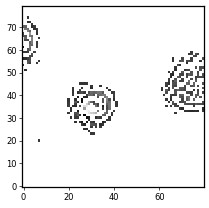

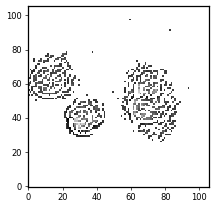

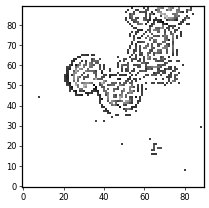

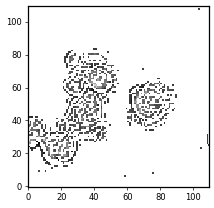

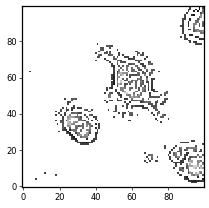

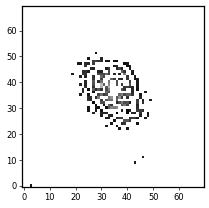

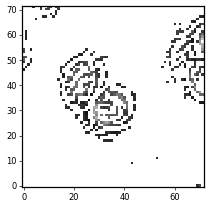

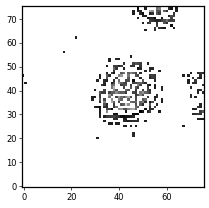

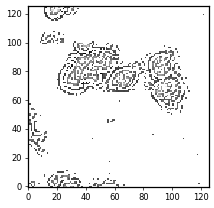

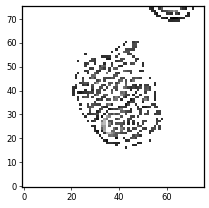

In [19]:
res_sizes=[]
for slicex in slices:
#     plt.figure(dpi=60)
#     plt.imshow(rescaled_img[slicex])
#     plt.title(ix)

    upscale = 1/downscale
    
    dim0_extent = [slicex[0].start*upscale,slicex[0].stop*upscale]
    dim0_center = int(np.mean(dim0_extent))

    dim1_extent = [slicex[1].start*upscale,slicex[1].stop*upscale]
    dim1_center = int(np.mean(dim1_extent))
    
    max_dim = int(np.max([np.diff(dim0_extent),np.diff(dim1_extent)])/2)
    
    if max_dim>64:
        print("too big a picture.")
        continue
    
    temp_X,temp_Y = np.mgrid[dim0_center-max_dim:dim0_center+max_dim, 
                                   dim1_center-max_dim:dim1_center+max_dim]
    final_slice_indices = np.vstack((temp_X.flatten(), temp_Y.flatten())).T
    
    extracted_image = np.zeros([max_dim*2, max_dim*2])
    for iix0,ix0 in enumerate(np.arange(dim0_center-max_dim, dim0_center+max_dim,1)):
        for iix1,ix1 in enumerate(np.arange(dim1_center-max_dim, dim1_center+max_dim,1)):
            extracted_image[iix0,iix1] = img_gray.take(ix0,axis=0,mode='wrap').take(ix1,mode='wrap')
    
#     print(max_dim, extracted_image.shape)
    
    extracted_image= extracted_image.astype(np.uint8)
#     extracted_image = cv2.cvtColor(extracted_image, cv2.COLOR_BGR2GRAY)
    
    thresh_gauss = cv2.adaptiveThreshold(extracted_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                        cv2.THRESH_BINARY, 3, 3)  


    mask0=1.0*(extracted_image>thresh_gauss)
    extracted_image = np.asarray(extracted_image, np.float64)
    mask0 = np.asarray(mask0, np.float64)
    extracted_image=cv2.multiply(extracted_image,mask0)
    extracted_image/=np.max(extracted_image)


    plt.figure(dpi=60)
    plt.imshow(extracted_image,cmap='gray_r')
#     plt.title(ix)